# Image Classification using CNN: Application in Recycling

**TL;DR:** This project uses a VGG16-based CNN to classify images of trash. The codes here present the central part: training the model, evaluating model performance, and visualizing its output using a examplar image.

## Part I: Set up and Training

This project is Khoa Lam's passion project at the Metis data science bootcamp in NYC. It uses CNN as a tool to classify recyclables to reduce contamination in trash. That being said, its goal has been considered by many other projects (e.g., [TrashNet](https://github.com/garythung/trashnet), [Multilayer Hybrid Deep-Learning Method for Waste Classification and Recycling](https://www.hindawi.com/journals/cin/2018/5060857/)) and organizations (e.g., [ZenRobotics](https://zenrobotics.com/)). My goal is to use a different data source (i.e., downloadable images) and to use open-source Python packages (e.g., pandas, numpy, keras, sklearn, openCV, PIL). The codes presented here are simplified to be run on a local machine. The full model, on the other hand, was trained on the AWS server, and achieved $F_{0.5}$ = 0.90 for recyclability, and averaged AUC = 0.75 for material classification. The final CNN was deployed into a Dash [web app](http://isitrecyc-dev.us-east-2.elasticbeanstalk.com/) on AWS Elastic Beanstalk.

Image sources for this project include: 
1. Google Image Search, URLs from Google Custom Search API (code in [getting-urls notebook](./getting-urls.ipynb))
2. [TrashNet](https://github.com/garythung/trashnet)
3. A subset of [Caltech 256 Image Dataset](https://www.kaggle.com/jessicali9530/caltech256)
4. A subset of [Flickr Material Database (FMD)](https://people.csail.mit.edu/celiu/CVPR2010/FMD/)

This model has two distinct outputs: (1) recyclability (binary output), and (2) material classification (categorical output). Recyclability is trained with $F_{0.5}$ as the metric, as $F_{0.5}$ weighs precision twice as much as recall (minimize true recyclable contamination). Material classification is trained with AUC to balance separation of one class from others. The first part here consists of:
1. Compiling the multi-output CNN based on VGG16 (i.e., transfer learning)
2. Customizing keras's flow_from_directory to work with multi-output tensor
3. Training a subset of images

In [13]:
import sys
import os

# pandas, numpy, matplotlib
import pandas as pd
% pylab inline
import seaborn as sns
sns.set()

# image processing imports
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# keras imports
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras.layers.core import Flatten, Dense, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, image

import functools
from keras import backend as K
import tensorflow as tf
from tensorflow import metrics

# sklearn
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

Populating the interactive namespace from numpy and matplotlib


/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mod', 'rec', 'shuffle', 'mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
# keras custom metrics for F1/2 and AUC
def true_pos(y_true, y_pred):
    return K.sum(y_true * K.round(y_pred)) + K.epsilon()
def false_pos(y_true, y_pred):
    return K.sum(y_true * (1. - K.round(y_pred))) + K.epsilon()
def false_neg(y_true, y_pred):
    return K.sum((1. - y_true) * K.round(y_pred)) + K.epsilon()
def precision(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_pos(y_true, y_pred))
def recall(y_true, y_pred):
    return true_pos(y_true, y_pred) / (true_pos(y_true, y_pred) + false_neg(y_true, y_pred))
def f12(y_true, y_pred):
    return ((1 + (0.5 ** 2)) * precision(y_true, y_pred) * recall(y_true, y_pred)) / ((0.5 ** 2) * precision(y_true, y_pred) + recall(y_true, y_pred))

def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        value, update = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update]):
            value = tf.identity(value)
        return value
    return wrapper
auc = as_keras_metric(metrics.auc)

In [15]:
# use VGG16 as the base CNN and ...
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ... retrain the top 4 convolution layers
for layer in vgg.layers[:-4]:
    layer.trainable = False

# add on custom dense layers
mod = vgg.output
mod = Flatten()(mod)
mod = Dense(1024, activation='relu')(mod)
mod = Dense(512, activation='relu')(mod)
mat = Dense(6, activation='softmax', name='class')(mod) # 2 final dense layers: 1 categorical output (materials)
rec = Dense(1, activation='sigmoid', name='recyc')(mod) # and 1 binary output (recyclable vs. non-recyclable)

# compile model
model = Model(inputs=vgg.input, outputs=[mat, rec])
model.compile(optimizer=Adam(lr=0.00001),
              loss={'recyc': 'binary_crossentropy', 'class': 'categorical_crossentropy'}, # 1 loss function for each output
              loss_weights={'recyc': 10, 'class': 1}, # arbitrary weights to counteract class imbalance
              metrics={'recyc': f12, 'class': auc}) # F1/2 weighs precision > recall, AUC works for imbalanced classes

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [16]:
# create custom dataframe to manage multi-output data files while utilizing keras flow_from_directory
# code adapted from https://kapernikov.com/multi-label-classification-with-keras/
dr = './data'
mats = {'paper': 0, 'glass': 1, 'metal': 2, 'tanglers': 3, 'plastic': 4, 'other': 5}
recops = {'nonrecs': 0, 'recs': 1}

flist = []
tups = []
for dirpaths, dirnames, files in os.walk(dr):
    for file in files:
        if file.endswith('.jpg'):
            flist = os.path.join(dirpaths, file)
            lbs = os.path.basename(dirpaths).split('_') # make sure folder name follows 'recyc_material' convention
            zrecops = np.zeros(1, np.float32) # convert labels (folder name) into tensors
            if lbs[0] == 'recs':
                zrecops[0] = 1
            else: zrecops[0] = 0
            if lbs[1] in mats: 
                zmats = np.zeros(len(mats), np.float32)
                zmats[mats[lbs[1]]] = 1
            tups.append((flist, np.concatenate((zmats, zrecops))))
            
img = pd.DataFrame(tups, columns=['path', 'outputs'])
img.head()

,path,outputs
0,./data/nonrecs_glass/glass-469.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,./data/nonrecs_glass/glass-333.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,./data/nonrecs_glass/glass-455.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,./data/nonrecs_glass/glass-441.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,./data/nonrecs_glass/glass-327.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [17]:
# customize flow_from_directory to use its filenames and classes attributes
def df_flow(gen, df, **dflow_args):
    dgen = gen.flow_from_directory(dr, class_mode='sparse', shuffle=False, **dflow_args)
    dgen.filenames = df['path'].values
    dgen.classes = np.stack(df['outputs'].values)
    dgen.samples = len(df)
    dgen.n = len(df)
    dgen._set_index_array()
    dgen.directory = ''
    print('Found {} images'.format(dgen.n))
    return dgen

def split_outs(gen):
    while True:
        d = next(gen)
        x = d[0]
        y = [d[1][:, :6], d[1][:, 6:]] # split 1 tensor into 2 output tensors (1st-5th for materials and 6th for recyclability)
        yield x, y

In [18]:
# train only a sample (increase sample size if trained with AWS)
img = img.sample(200)

# train-validate split 80/20 (split once more to get train-validate-test split)
imgtr = shuffle(img.sample(frac=0.8, random_state=1))
imgval = shuffle(img.drop(imgtr.index))

In [19]:
# train with image augmentation, validate without
idgtr = ImageDataGenerator(rescale=1./255,
                           rotation_range=10,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.1,
                           zoom_range=0.2,
                           horizontal_flip=True)
idgval = ImageDataGenerator(rescale=1./255)

bsize = 10 # arbitrary, default 32
dgentr = df_flow(idgtr, imgtr, target_size=(224, 224), batch_size=bsize)
dgenval = df_flow(idgval, imgval, target_size=(224, 224), batch_size=bsize)

tr = split_outs(dgentr)
val = split_outs(dgenval)

Found 11037 images belonging to 8 classes.
Found 160 images
Found 11037 images belonging to 8 classes.
Found 40 images


In [20]:
# training montage!
trsteps = dgentr.samples // bsize
valsteps = dgenval.samples // bsize

montage = model.fit_generator(tr, steps_per_epoch=trsteps,
                              epochs=2, # arbitrary, higher epochs more training time
                              validation_data=val,
                              validation_steps=valsteps)

Epoch 1/2
16/16 [==============================] - 184s 12s/step - loss: 8.0180 - class_loss: 1.6965 - recyc_loss: 0.6321 - class_auc: 0.5592 - recyc_f12: 0.8062 - val_loss: 7.9158 - val_class_loss: 1.5205 - val_recyc_loss: 0.6395 - val_class_auc: 0.6582 - val_recyc_f12: 0.8876
Epoch 2/2
16/16 [==============================] - 80s 5s/step - loss: 7.1503 - class_loss: 1.5802 - recyc_loss: 0.5570 - class_auc: 0.6905 - recyc_f12: 0.8883 - val_loss: 7.8192 - val_class_loss: 1.4869 - val_recyc_loss: 0.6332 - val_class_auc: 0.6973 - val_recyc_f12: 0.8370


In [ ]:
# save model
model.save('base_mod.h5')

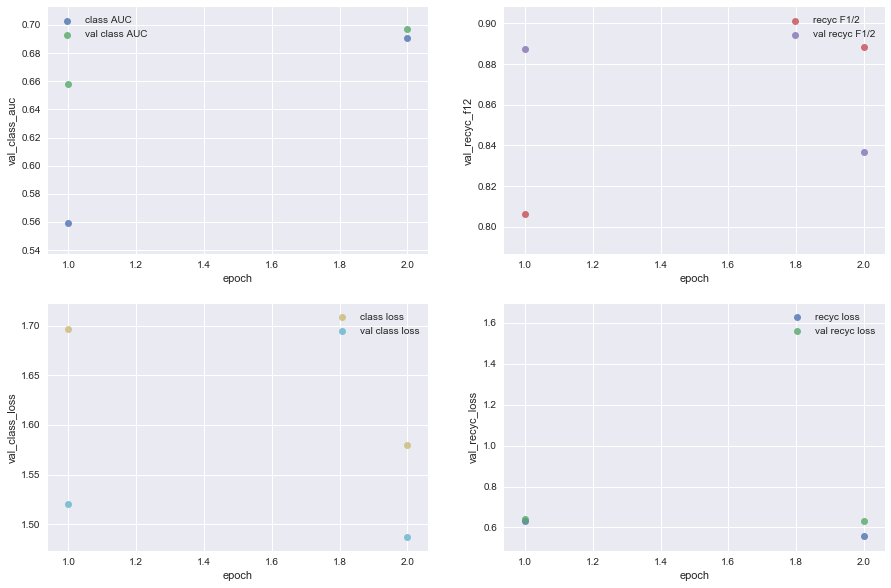

In [41]:
# visualize training history
htr = pd.DataFrame(montage.history)
htr['epoch'] = range(1, len(htr) + 1)

fig, ax = subplots(2, 2, figsize=(15, 10))
p1 = sns.regplot('epoch', 'class_auc', label='class AUC', data=htr, fit_reg=False, ax=ax[0, 0])
p2 = sns.regplot('epoch', 'val_class_auc', label='val class AUC', data=htr, fit_reg=False, ax=ax[0, 0])
p1.legend()

p1 = sns.regplot('epoch', 'recyc_f12', label='recyc F1/2', data=htr, fit_reg=False, ax=ax[0, 1])
p2 = sns.regplot('epoch', 'val_recyc_f12', label='val recyc F1/2', data=htr, fit_reg=False, ax=ax[0, 1])
p1.legend()

p1 = sns.regplot('epoch', 'class_loss', label='class loss', data=htr, fit_reg=False, ax=ax[1, 0])
p2 = sns.regplot('epoch', 'val_class_loss', label='val class loss', data=htr, fit_reg=False, ax=ax[1, 0])
p1.legend()

p1 = sns.regplot('epoch', 'recyc_loss', label='recyc loss', data=htr, fit_reg=False, ax=ax[1, 1])
p2 = sns.regplot('epoch', 'val_recyc_loss', label='val recyc loss', data=htr, fit_reg=False, ax=ax[1, 1])
p1.legend();

## Part II: Evaluating Validation/Test Set

The second part includes:
1. Re-predicting the validation/test set
2. Visualizing using various model evaluation tools
    1. Confusion matrix
    2. Classification report
    3. Writing custom function to visualize specific mislabels

In [42]:
# load model
model = load_model('./best_mod.h5', custom_objects={'auc': auc,
                                                    'recall': recall,
                                                    'f12': f12})

/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [43]:
# re-predict validation set
ypred = model.predict_generator(val, steps=valsteps, verbose=1)

# one-hot encode output tensors
yp = [np.argmax(ypred[0], axis=-1), np.round(ypred[1]).reshape(-1)]

4/4 [==============================] - 15s 4s/step


In [44]:
# list of true labels
yval = imgval.apply(lambda i: i['path'].split('/')[2].split('_'), axis=1, result_type='expand')
yval.columns = ['recyc', 'class']
yval = [np.array(yval['class'].apply(lambda i: mats[i])), np.array(yval['recyc'].apply(lambda i: recops[i]))]

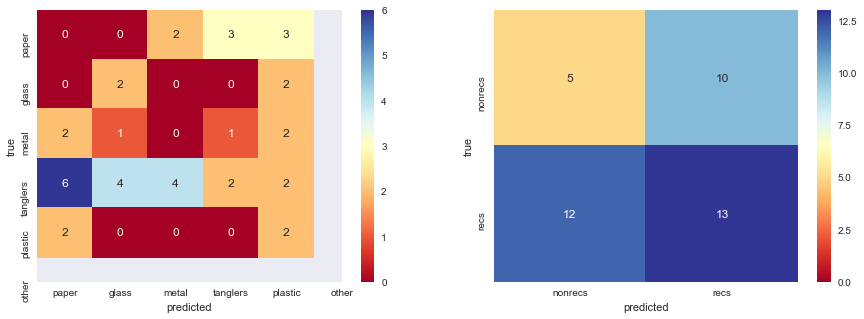

In [45]:
# confusion matrix for each output
fig, ax = subplots(1, 2, figsize=(15, 5))
p1 = sns.heatmap(confusion_matrix(yval[0], yp[0]), annot=True, fmt='g', vmin=0,
                 xticklabels=sorted(mats, key=mats.get), yticklabels=sorted(mats, key=mats.get),
                 cmap='RdYlBu', ax=ax[0])
p1.set_xlabel('predicted')
p1.set_ylabel('true')

p2 = sns.heatmap(confusion_matrix(yval[1], yp[1]), annot=True, fmt='g', vmin=0,
                 xticklabels=sorted(recops, key=recops.get), yticklabels=sorted(recops, key=recops.get),
                 cmap='RdYlBu', ax=ax[1]);
p2.set_xlabel('predicted')
p2.set_ylabel('true');

In [47]:
# classification report for each output
print(classification_report(yval[0], yp[0], target_names=sorted(mats, key=mats.get)))
print(classification_report(yval[1], yp[1], target_names=sorted(recops, key=recops.get)))

             precision    recall  f1-score   support

      paper       0.00      0.00      0.00         8
      glass       0.29      0.50      0.36         4
      metal       0.00      0.00      0.00         6
   tanglers       0.33      0.11      0.17        18
    plastic       0.18      0.50      0.27         4

avg / total       0.20      0.15      0.14        40

             precision    recall  f1-score   support

    nonrecs       0.29      0.33      0.31        15
       recs       0.57      0.52      0.54        25

avg / total       0.46      0.45      0.46        40



/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 6
  .format(len(labels), len(target_names))


predicted : paper 	 true : plastic


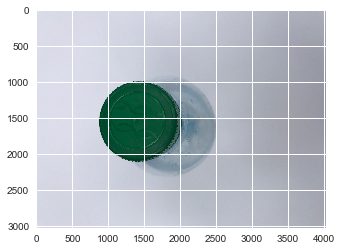

predicted : paper 	 true : plastic


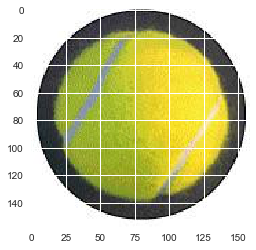

In [50]:
dmats = dict([(v, k) for k, v in mats.items()])
drecops = dict([(v, k) for k, v in recops.items()])

imgchk = pd.DataFrame()
imgchk['path'] = imgval['path']
imgchk['pred'] = [dmats[i] for i in yp[0]]
imgchk['true'] = [dmats[i] for i in yval[0]]

# visualizing specific mislabels
imgs = imgchk[(imgchk['true'] == 'plastic') & (imgchk['pred'] == 'paper')].sample(2).values # plastic mislabeled as paper?
for i in imgs:
    print('predicted :', i[1], '\t', 'true :', i[2])
    imgplot = plt.imshow(mpimg.imread(i[0]))
    plt.show()

## Part III: Visualizing One Specific Image

All codes are adapted from [Deep Learning with Python](http://bioserver.cpgei.ct.utfpr.edu.br/disciplinas/eeica/papers/Livros/%5BChollet%5D-Deep_Learning_with_Python.pdf) book. The final part includes:
1. Visualizing convolutional layer outputs
2. Visualizing superimposed heat map generated by output of the last convolutional layer

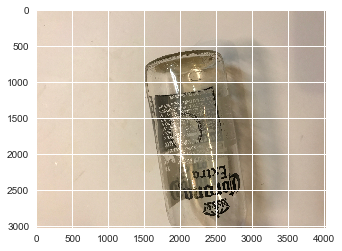

In [51]:
# code adapted from Deep Learning with Python by F. Chollet
rand = './data/recs_glass/'
p = rand + np.random.choice(os.listdir(rand))
imgplot = plt.imshow(mpimg.imread(p))
plt.show()

In [52]:
_imgts = image.load_img(p, target_size=(224, 224))
_imgts = image.img_to_array(_imgts)
imgts = np.expand_dims(_imgts, axis=0)
imgts /= 255

In [56]:
outs = [layer.output for layer in model.layers[1:-5]]
actmod = Model(inputs=model.input, outputs=outs)
acts = actmod.predict(imgts)
len(acts) # number of convolution layers

18

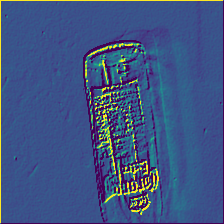

In [60]:
nlayer = 0 # convolution layer number
nchannel = 0 # channel number (varies based on the layer number)
ts = acts[nlayer][0, :, :, nchannel]
Image.fromarray(np.uint8(plt.cm.viridis_r(ts) * 255))

In [61]:
conv = model.get_layer('block5_pool') # get last convolution layer
grads = K.gradients(model.output, conv.output)[0]
pgrads = K.mean(grads, axis=(0, 1, 2))
itr = K.function([model.input], [pgrads, conv.output[0]])

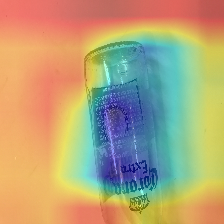

In [62]:
pgradsval, convval = itr([imgts])
for i in range(512):
    convval[:, :, i] *= pgradsval[i]
hmap = np.mean(convval, axis=-1)
hmap = np.maximum(hmap, 0)
hmap /= np.max(hmap)
hmap = cv2.resize(hmap, (_imgts.shape[1], _imgts.shape[0]))
hmap = np.uint8(255 * hmap)
hmap = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
imgs = hmap * 0.8 + _imgts * 255
image.array_to_img(imgs)